<a href="https://colab.research.google.com/github/cesar-claros/RL_tutorial/blob/main/RL_maze_tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/cesar-claros/RL_tutorial
% cd RL_tutorial/

Cloning into 'RL_tutorial'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 18 (delta 4), reused 15 (delta 4), pack-reused 0
Unpacking objects: 100% (18/18), done.
/content/RL_tutorial


In [2]:
# Librerías 
#----------
import env_maze
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np # librería de procesamiento numérico 
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
from tqdm import tqdm
from IPython import display

<figure>
<center>
<img src='https://www.samyzaf.com/ML/rl/images/maze1a.png' width="300"/>
<figcaption>Ilustración de laberinto. Credito: https://www.samyzaf.com/ML/rl/qmaze.html </figcaption>
</center>
</figure>


In [3]:
maze = np.array( [
    [ 1.0,  0.0,  0.0,  1.0,  1.0,  1.0,  1.0,  1.0],
    [ 1.0,  0.0,  1.0,  1.0,  1.0,  0.0,  1.0,  1.0],
    [ 1.0,  1.0,  0.0,  1.0,  1.0,  1.0,  0.0,  1.0],
    [ 1.0,  1.0,  1.0,  1.0,  1.0,  0.0,  1.0,  1.0],
    [ 0.0,  1.0,  1.0,  0.0,  0.0,  1.0,  1.0,  1.0],
    [ 1.0,  1.0,  1.0,  1.0,  0.0,  1.0,  0.0,  0.0],
    [ 1.0,  0.0,  1.0,  0.0,  1.0,  1.0,  1.0,  1.0],
    [ 0.0,  1.0,  1.0,  0.0,  1.0,  1.0,  1.0,  1.0]
] )

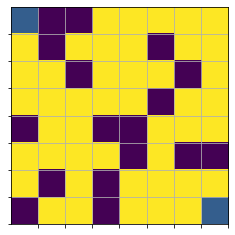

In [4]:
qmaze = env_maze.Qmaze(maze)
env_maze.show(qmaze)

In [5]:
# Encoded movements
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

<figure>
<center>
<img src='https://www.samyzaf.com/ML/rl/images/maze1b.png' width="300"/>
<figcaption>Codificación de las posilbles acciones. Credito: https://www.samyzaf.com/ML/rl/qmaze.html </figcaption></center>
</figure>

## Recompesas (Rewards):

- Cada movimiento a una celda adyacente válida genera una recompensa -0.04
- Cada movimiento a una celda adyacente inválida (obstáculo) genera una recompensa igual -0.75
- Cada intento de movimiento fuera de los límites del laberinto genera una recompensa igual -0.75
- Cada movimiento de retorno a una celda previamente visitada genera una recompensa igual -0.25
- Si llegamos al objetivo final la recompensa es 1.0 
- Para evitar bucles infinitos, el juego se da por terminado una vez que la recompensa total cae por debajo de -0.5*maze.size
- El juego se da por terminado también si el agente llega al objetivo final.

<figure>
<center>
<img src='https://www.samyzaf.com/ML/rl/images/mdp1.png' width="1000"/>
<figcaption>Ilustración de los estados del laberinto. Credito: https://www.samyzaf.com/ML/rl/qmaze.html </figcaption>

</center>
</figure>

reward= -0.04


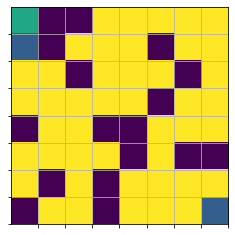

In [6]:
canvas, reward, game_over = qmaze.act(DOWN)
print("recompensa=", reward)
env_maze.show(qmaze)

recompensa = -0.04
estado = ((2, 0, 'valid'))


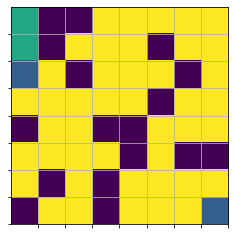

In [9]:
# Ejecutar acción
canvas, reward, game_over = qmaze.act(DOWN)
# Observar el ambiente (environment)
print("recompensa =", reward)
print("estado = ({})".format(qmaze.state)) #(FILA,COLUMNA)
env_maze.show(qmaze)

## Ambiente (environment):
<figure>
<center>
<img src='https://player.slideplayer.com/105/17624990/slides/slide_4.jpg' width="500"/>
<figcaption>Credito: https://www.davidsilver.uk/wp-content/uploads/2020/03/intro_RL.pdf </figcaption>
</center>
</figure>

## Problema: 
Encontrar una política (policy) $\pi^*:\mathcal{S}\rightarrow\mathcal{A}$

Por ejemplo: si $s=(0,0)\in\mathcal{S}$, la política óptima $\pi^*(s)=E(\rightarrow)$

## Solución deseada:
<figure>
<center>
<img src='https://player.slideplayer.com/105/17624990/slides/slide_5.jpg' width="500"/>
<figcaption>Credito: https://www.davidsilver.uk/wp-content/uploads/2020/03/intro_RL.pdf </figcaption>

</center>
</figure>





(0, 0, 'start')


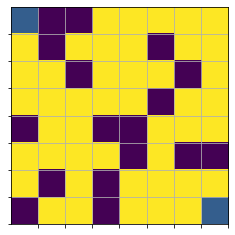

In [10]:
# Reiniciar el ambiente
qmaze.reset((0,0))
print(qmaze.state)
env_maze.show(qmaze)

In [241]:
# Generar tabla de valores (V_table)
def init_V_table(shape):
    # V_table = np.random.normal(loc=0.0,scale=0.1,size=shape)# (size=V_table_shape)
    V_table = np.zeros(shape)
    V_table[~np.array(maze).astype('bool')] = np.nan
    return V_table


In [232]:
# Iniciar tabla de valores (V_table)
V_table = init_V_table(maze.shape)
# Tabla de valores inicial
pd.DataFrame(V_table)

,0,1,2,3,4,5,6,7
0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1,0.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0
2,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0
3,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
4,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN
6,0.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0
7,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0


In [283]:
def select_action(V_table, state, explore_rate):
    # Encoded movements
    # LEFT = 0
    # UP = 1
    # RIGHT = 2
    # DOWN = 3

    # Select a random action
    if random.random() < explore_rate:
        action = np.random.randint(num_actions)
    # Select the action with the highest v
    else:
        state = np.array(state[:2])
        values_list = []
        left, up, right, down = np.array([0,-1]), np.array([-1,0]), np.array([0,1]), np.array([1,0])
        for mov in [left,up,right,down]:
            s_ = state + mov
            # print(s_)
            if s_.min()<0 or s_.max()>=8: # inside boundaries?
                values_list.append(np.nan) 
                continue
            else:
                values_list.append(V_table[tuple(s_)]) # accumulate V function values

        # print(values_list)    
        action = int(np.nanargmax(values_list)) # greedy policy 
    return action

In [178]:
# Escoger acción basado en la política
exploration_rate = 0.1
action = select_action(V_table, qmaze.state, exploration_rate)

In [197]:
# Generar tabla de acciones inicial
def init_action_table(shape):
    action_table = -np.ones(shape) 
    action_table_shape = a_table.shape # (8,8)
    action_table[~np.array(maze).astype('bool')] = np.nan
    return action_table

In [199]:
#Iniciar tabla de actiones
action_table = init_action_table(maze.shape)
# Table de acciones
pd.DataFrame(action_table)

,0,1,2,3,4,5,6,7
0,-1.0,NaN,NaN,-1.0,-1.0,-1.0,-1.0,-1.0
1,-1.0,NaN,-1.0,-1.0,-1.0,NaN,-1.0,-1.0
2,-1.0,-1.0,NaN,-1.0,-1.0,-1.0,NaN,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,-1.0,-1.0
4,NaN,-1.0,-1.0,NaN,NaN,-1.0,-1.0,-1.0
5,-1.0,-1.0,-1.0,-1.0,NaN,-1.0,NaN,NaN
6,-1.0,NaN,-1.0,NaN,-1.0,-1.0,-1.0,-1.0
7,NaN,-1.0,-1.0,NaN,-1.0,-1.0,-1.0,-1.0


In [200]:
# Tabla de acciones inical
pd.DataFrame(V_table)

,0,1,2,3,4,5,6,7
0,-0.014357,NaN,NaN,-0.078508,0.138790,0.005406,-0.028817,-0.075848
1,-0.018393,NaN,0.049844,0.029668,-0.057994,NaN,0.040547,-0.039688
2,-0.047327,0.044541,NaN,0.052012,0.075199,-0.242778,NaN,-0.015710
3,-0.177447,-0.002482,-0.053609,-0.100560,-0.130847,NaN,-0.063677,-0.300711
4,NaN,0.161976,-0.056162,NaN,NaN,0.055167,-0.055503,-0.001470
5,-0.070258,-0.054838,0.059866,-0.112945,NaN,0.092802,NaN,NaN
6,-0.079372,NaN,0.002623,NaN,-0.008160,-0.212706,0.038816,-0.105833
7,NaN,0.081142,-0.189194,NaN,0.063983,0.068434,-0.092102,-0.144734


In [201]:
def update_action_table(action_table, state, action):
    state = np.array(state[:2])
    action_table[tuple(state)] = action
    return action_table

In [202]:
action_table = update_action_table(action_table, qmaze.state, action)
pd.DataFrame(action_table)

,0,1,2,3,4,5,6,7
0,-1.0,NaN,NaN,-1.0,-1.0,-1.0,-1.0,-1.0
1,3.0,NaN,-1.0,-1.0,-1.0,NaN,-1.0,-1.0
2,-1.0,-1.0,NaN,-1.0,-1.0,-1.0,NaN,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,NaN,-1.0,-1.0
4,NaN,-1.0,-1.0,NaN,NaN,-1.0,-1.0,-1.0
5,-1.0,-1.0,-1.0,-1.0,NaN,-1.0,NaN,NaN
6,-1.0,NaN,-1.0,NaN,-1.0,-1.0,-1.0,-1.0
7,NaN,-1.0,-1.0,NaN,-1.0,-1.0,-1.0,-1.0


In [203]:
# Almacenar estado actual
state = qmaze.state
# Ejecutar acción
canvas, reward, game_over = qmaze.act(action)
# Alamcear estado nuevo
state_ = qmaze.state

(2, 0, 'valid')


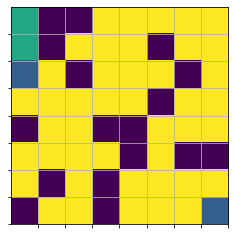

In [205]:
print(state_)
env_maze.show(qmaze)

In [216]:
def update_V_table(V_table, state, state_, reward, alpha=0.05, gamma=0.90):
    # alpha -> learning rate
    # gamma -> discount factor
    state = np.array(state[:2])
    state_ = np.array(state_[:2])
    V_table[tuple(state)] = (1-alpha)*V_table[tuple(state)] + alpha*(reward + gamma*V_table[tuple(state_)])
    return V_table

In [207]:
V_table = update_V_table(V_table, state, state_, reward)
pd.DataFrame(V_table)

,0,1,2,3,4,5,6,7
0,-0.014357,NaN,NaN,-0.078508,0.138790,0.005406,-0.028817,-0.075848
1,-0.025049,NaN,0.049844,0.029668,-0.057994,NaN,0.040547,-0.039688
2,-0.047327,0.044541,NaN,0.052012,0.075199,-0.242778,NaN,-0.015710
3,-0.177447,-0.002482,-0.053609,-0.100560,-0.130847,NaN,-0.063677,-0.300711
4,NaN,0.161976,-0.056162,NaN,NaN,0.055167,-0.055503,-0.001470
5,-0.070258,-0.054838,0.059866,-0.112945,NaN,0.092802,NaN,NaN
6,-0.079372,NaN,0.002623,NaN,-0.008160,-0.212706,0.038816,-0.105833
7,NaN,0.081142,-0.189194,NaN,0.063983,0.068434,-0.092102,-0.144734


In [292]:
# Establecer 'seed'
#------------------
seed = 123
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
# Parámetros (hyper-parameters)
#-----------
init_pos = (0,0)
exploration_rate = 0.20
NUM_EPISODES = 1000
alpha = 0.1 #-> learning rate
gamma = 0.95 #-> discount factor 

# Algoritmo
#----------
# Iniciar tabla de valores (V_table)
V_table = init_V_table(maze.shape)
for _ in tqdm(range(NUM_EPISODES)):
    # Iniciar laberinto
    qmaze.reset(init_pos)
    # Almacenar estado actual
    state = qmaze.state
    while qmaze.game_status()=='not_over':
        # Seleccionar acción
        action = select_action(V_table, state, exploration_rate)
        # Ejecutar acción
        canvas, reward, game_over = qmaze.act(action)
        # Almacenar estado nuevo
        state_ = qmaze.state
        # Actualizar V_table
        V_table = update_V_table(V_table, state, state_, reward, alpha=alpha, gamma=gamma)
        # Reasignar estado
        state = state_

100%|██████████| 1000/1000 [00:04<00:00, 212.50it/s]


In [293]:
pd.DataFrame(V_table)

,0,1,2,3,4,5,6,7
0,-1.184277,NaN,NaN,-1.058357,-0.864138,-0.834799,-0.802037,-0.787719
1,-1.135516,NaN,-1.188818,-1.012847,-0.885577,NaN,-0.733144,-0.621252
2,-1.087002,-1.056854,NaN,-0.925121,-0.893130,-1.187474,NaN,-0.541603
3,-1.160347,-1.015452,-0.986507,-0.955302,-1.005788,NaN,-0.411249,-0.520865
4,NaN,-1.297803,-1.251756,NaN,NaN,-0.330384,-0.329975,-0.538680
5,-1.249484,-1.262920,-1.256683,-1.237560,NaN,-0.269334,NaN,NaN
6,-1.227350,NaN,-1.251445,NaN,-0.395546,-0.102075,-0.010680,0.200751
7,NaN,-1.219908,-1.255490,NaN,-0.381875,-0.044995,0.280100,0.000000


In [338]:
fig, ax = plt.subplots(figsize=(5,5))
# Iniciar tabla de acciones
action_table = init_action_table(maze.shape)
qmaze.reset(init_pos)
# Almacenar estado actual
state = qmaze.state
imgs = []
# Concatenar imagenes
img = env_maze.show(qmaze)
imgs.append([img])
# ims = []
while qmaze.game_status()=='not_over':
    # Seleccionar acción
    action = select_action(V_table, state, -1.0)
    # Actualizar action_table
    action_table = update_action_table(action_table, state, action)
    # Ejecutar acción
    canvas, reward, game_over = qmaze.act(action)
    # Reasignar estado
    state = qmaze.state
    # Concatenar imagenes
    img = env_maze.show(qmaze)
    imgs.append([img])

ani = animation.ArtistAnimation(fig, imgs, interval=500, blit=True,
                                repeat_delay=1000)
plt.close()

In [339]:
display.HTML(ani.to_html5_video())

In [ ]:
# Encoded movements
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3
